# 🔬 W02 — BI Fusion Pipeline Validation
**Objective**: Test the complete preprocessing pipeline with BI integration (Section III-B of the methodology).

**Pipeline under test:**
1. Load C-MAPSS sensor data → `data_loader.py`
2. Normalize sensor features (MinMax) → `preprocessing.py`
3. Fuse with BI data (forward-fill, one-hot encoding) → `bi_fusion.py` (Section III-B3)
4. BI-aware feature selection (variance + correlation) → `feature_selection.py` (Section III-B4)

**Author**: Fatima Khadija Benzine  
**Date**: February 13 2026

---
## 0. Setup

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Navigate up to project root so we can import from src/
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'src'))

print(f"Project root: {project_root}")
print(f"Expected src/: {project_root / 'src'}")
print(f"Expected data/: {project_root / 'data'}")

# Verify files exist
for f in ['src/data_loader.py', 'src/bi_fusion.py', 'src/feature_selection.py', 'src/preprocessing.py']:
    p = project_root / f
    status = '✓' if p.exists() else '✗ MISSING'
    print(f"  {status}  {f}")

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

Project root: C:\Users\fatim\Desktop\Phd-Project-\PhD-Project-
Expected src/: C:\Users\fatim\Desktop\Phd-Project-\PhD-Project-\src
Expected data/: C:\Users\fatim\Desktop\Phd-Project-\PhD-Project-\data
  ✓  src/data_loader.py
  ✓  src/bi_fusion.py
  ✓  src/feature_selection.py
  ✓  src/preprocessing.py


In [2]:
from data_loader import MultiDatasetLoader
from preprocessing import PreprocessingPipelineBI
from bi_fusion import BIFusionPipeline, BIDataLoader, BI_DELTA_CONFIG
from feature_selection import BIAwareFeatureSelector

print("All modules imported successfully ✓")

All modules imported successfully ✓


---
## 1. Load Raw Data

In [3]:
loader = MultiDatasetLoader()

print("Loading FD001...")
fd001 = loader.load_fd001()
train_raw = fd001['train']
test_raw = fd001['test']

print(f"\nTrain: {train_raw.shape}")
print(f"Test:  {test_raw.shape}")
print(f"Units: {train_raw['unit'].nunique()} train, {test_raw['unit'].nunique()} test")
print(f"Columns: {list(train_raw.columns[:8])}...")
train_raw.head()

Loading FD001...
Loading FD001 dataset...
  Files: train=True, test=True, rul=True
  - Training data shape: (20631, 26)
  - Training units: 100
  - Training RUL range: [0, 361]
  - Test data shape: (13096, 26)
  - RUL values shape: (100, 1)
  - Test units found: 100 (units: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]...)
  - RUL values provided: 100
    Unit 1: max_cycle=31, base_RUL=112
    Unit 2: max_cycle=49, base_RUL=98
    Unit 3: max_cycle=126, base_RUL=69
✓ FD001 loaded: 20631 train, 13096 test samples

Train: (20631, 27)
Test:  (13096, 27)
Units: 100 train, 100 test
Columns: ['unit', 'cycle', 'setting_1', 'setting_2', 'setting_3', 'sensor_1', 'sensor_2', 'sensor_3']...


,unit,cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


---
## 2. Inspect BI Data (before fusion)

In [4]:
bi_loader = BIDataLoader()
bi_df = bi_loader.load_bi('FD001')

print(f"BI data shape: {bi_df.shape}")
print(f"\nColumns: {list(bi_df.columns)}")
print(f"\nUpdate frequencies (Delta_k):")
print(bi_loader.get_delta_summary().to_string(index=False))

bi_df.head(10)

  BI data loaded: 20631 rows, 100 units
BI data shape: (20631, 15)

Columns: ['unit_id', 'cycle', 'pm_cost', 'cm_cost', 'labor_rate_standard', 'labor_rate_overtime', 'production_priority', 'downtime_penalty', 'revenue_per_hour', 'spare_parts_available', 'spare_parts_lead_time', 'technician_available', 'maintenance_window', 'shift_pattern', 'contract_penalty_active']

Update frequencies (Delta_k):
               variable  delta_cycles source_system    var_type
                pm_cost            50           ERP  continuous
                cm_cost            50           ERP  continuous
    labor_rate_standard            50           ERP  continuous
    labor_rate_overtime            50           ERP  continuous
    production_priority            10           MES categorical
       downtime_penalty            10           MES  continuous
     maintenance_window            10           MES      binary
          shift_pattern            10           MES categorical
       revenue_per_hour 

,unit_id,cycle,pm_cost,cm_cost,labor_rate_standard,labor_rate_overtime,production_priority,downtime_penalty,revenue_per_hour,spare_parts_available,spare_parts_lead_time,technician_available,maintenance_window,shift_pattern,contract_penalty_active
0,1,1,511.18,3464.88,79.83,130.46,0,5104.43,7748.23,1,1,1,1,0,0
1,1,2,511.18,3464.88,79.83,130.46,0,5104.43,7748.23,1,1,1,1,0,0
2,1,3,511.18,3464.88,79.83,130.46,0,5104.43,7748.23,1,1,1,1,0,0
3,1,4,511.18,3464.88,79.83,130.46,0,5104.43,7748.23,1,1,1,1,0,0
4,1,5,511.18,3464.88,79.83,130.46,0,5104.43,7748.23,1,1,1,1,0,0
5,1,6,511.18,3464.88,79.83,130.46,0,5104.43,7748.23,1,1,1,1,0,0
6,1,7,511.18,3464.88,79.83,130.46,0,5104.43,7748.23,1,1,1,1,0,0
7,1,8,511.18,3464.88,79.83,130.46,0,5104.43,7748.23,1,1,1,1,0,0
8,1,9,511.18,3464.88,79.83,130.46,0,5104.43,7748.23,1,1,1,1,0,0
9,1,10,511.18,3464.88,79.83,130.46,0,5104.43,7748.23,1,1,1,1,0,0


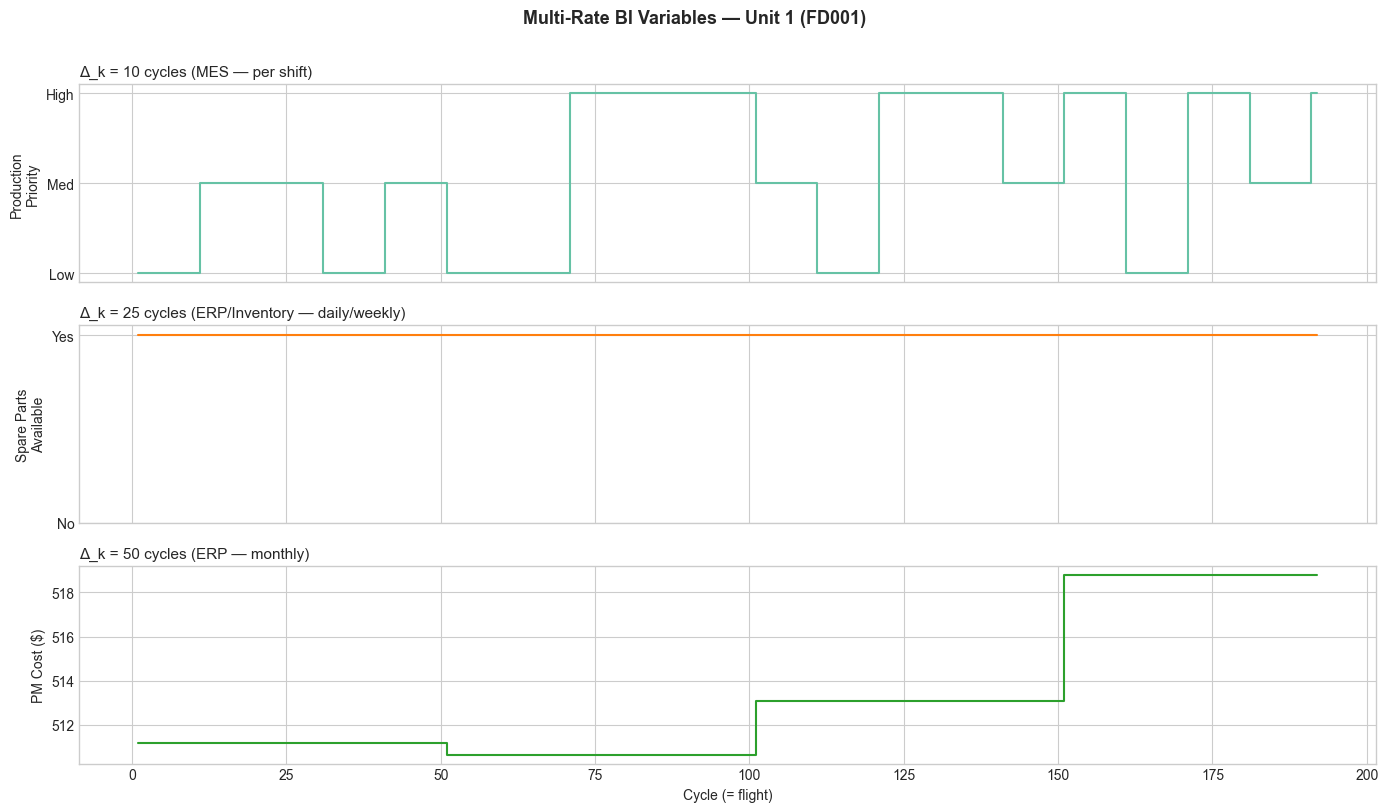

In [5]:
# Visualize Delta behavior: BI variables stay constant within each Delta_k period
unit1_bi = bi_df[bi_df['unit_id'] == 1].set_index('cycle')

fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

# Delta=10: production_priority
axes[0].step(unit1_bi.index, unit1_bi['production_priority'], where='post', linewidth=1.5)
axes[0].set_ylabel('Production\nPriority')
axes[0].set_title('Δ_k = 10 cycles (MES — per shift)', fontsize=11, loc='left')
axes[0].set_yticks([0, 1, 2])
axes[0].set_yticklabels(['Low', 'Med', 'High'])

# Delta=25: spare_parts_available
axes[1].step(unit1_bi.index, unit1_bi['spare_parts_available'], where='post', 
             linewidth=1.5, color='tab:orange')
axes[1].set_ylabel('Spare Parts\nAvailable')
axes[1].set_title('Δ_k = 25 cycles (ERP/Inventory — daily/weekly)', fontsize=11, loc='left')
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['No', 'Yes'])

# Delta=50: pm_cost
axes[2].step(unit1_bi.index, unit1_bi['pm_cost'], where='post', 
             linewidth=1.5, color='tab:green')
axes[2].set_ylabel('PM Cost ($)')
axes[2].set_title('Δ_k = 50 cycles (ERP — monthly)', fontsize=11, loc='left')
axes[2].set_xlabel('Cycle (= flight)')

fig.suptitle('Multi-Rate BI Variables — Unit 1 (FD001)', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
## 3. Validate Degradation Correlation
Per the mixed correlation design: `production_priority` and `downtime_penalty` should increase as the engine approaches failure.

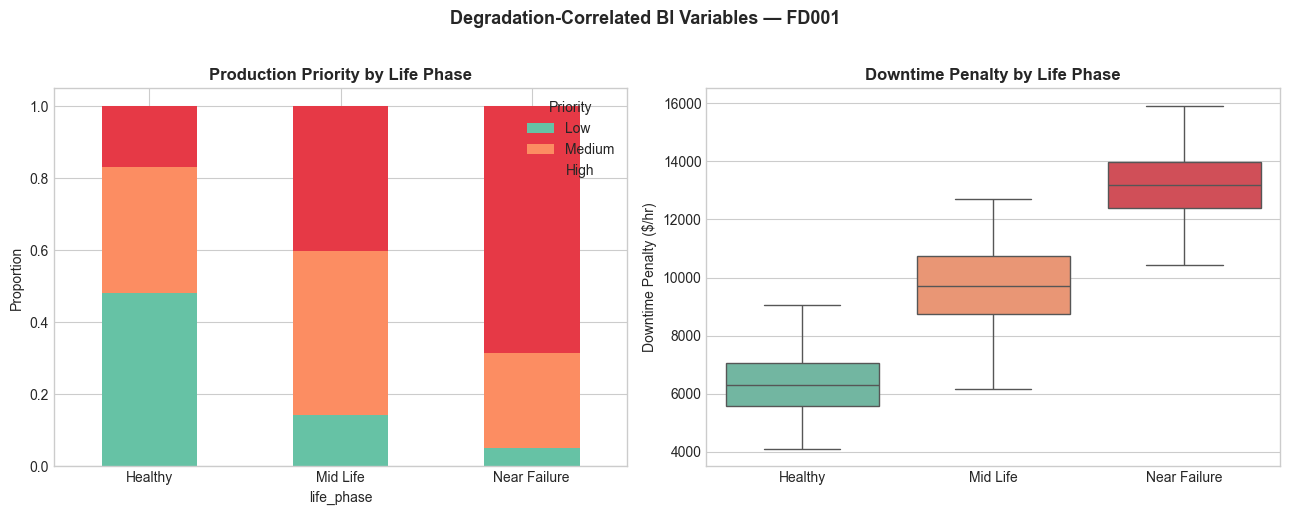

Mean production_priority by phase:
life_phase
Healthy         0.686450
Mid Life        1.258439
Near Failure    1.634111
Name: production_priority, dtype: float64

Mean downtime_penalty by phase:
life_phase
Healthy          6291.835648
Mid Life         9712.536719
Near Failure    13194.225839
Name: downtime_penalty, dtype: float64


In [6]:
# Add health index to BI data for analysis
bi_with_hi = bi_df.copy()
max_cycles = bi_with_hi.groupby('unit_id')['cycle'].transform('max')
bi_with_hi['health_index'] = 1.0 - (bi_with_hi['cycle'] / max_cycles)
bi_with_hi['life_phase'] = pd.cut(bi_with_hi['health_index'], 
                                   bins=[0, 0.3, 0.7, 1.0],
                                   labels=['Near Failure', 'Mid Life', 'Healthy'])

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Production priority distribution by life phase
phase_priority = bi_with_hi.groupby('life_phase')['production_priority'].value_counts(normalize=True)
phase_priority = phase_priority.unstack(fill_value=0)
phase_priority.columns = ['Low', 'Medium', 'High']
phase_priority.loc[['Healthy', 'Mid Life', 'Near Failure']].plot(
    kind='bar', stacked=True, ax=axes[0], color=['#66c2a5', '#fc8d62', '#e63946'])
axes[0].set_title('Production Priority by Life Phase', fontweight='bold')
axes[0].set_ylabel('Proportion')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].legend(title='Priority')

# Downtime penalty by life phase
order = ['Healthy', 'Mid Life', 'Near Failure']
bi_with_hi['life_phase'] = pd.Categorical(bi_with_hi['life_phase'], categories=order, ordered=True)
sns.boxplot(data=bi_with_hi, x='life_phase', y='downtime_penalty', ax=axes[1],
            order=order, palette=['#66c2a5', '#fc8d62', '#e63946'])
axes[1].set_title('Downtime Penalty by Life Phase', fontweight='bold')
axes[1].set_ylabel('Downtime Penalty ($/hr)')
axes[1].set_xlabel('')

fig.suptitle('Degradation-Correlated BI Variables — FD001', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Mean production_priority by phase:")
print(bi_with_hi.groupby('life_phase')['production_priority'].mean())
print("\nMean downtime_penalty by phase:")
print(bi_with_hi.groupby('life_phase')['downtime_penalty'].mean())

---
## 4. Run Full Pipeline

In [7]:
pipeline = PreprocessingPipelineBI(
    normalization_method='minmax',
    variance_threshold=0.01,
    correlation_threshold=0.95,
    rul_max=125,
)

train_processed = pipeline.fit_transform(train_raw, 'FD001')

PREPROCESSING PIPELINE — FD001

[Step 0] RUL clipped to max=125

[Step 1] Columns: 21 sensor, 3 setting

[Step 2] Normalized 24 features (minmax)

=== BI Fusion: FD001 (train) ===
  Sensor data: (20631, 27)
  BI data loaded: 20631 rows, 100 units
  Fused data: (20631, 44)
  Features: 21 sensor + 17 BI

[Step 3b] Normalized 7 continuous BI features (minmax)
  Normalized: ['pm_cost', 'cm_cost', 'labor_rate_standard', 'labor_rate_overtime', 'downtime_penalty', 'revenue_per_hour', 'spare_parts_lead_time']
  Kept as-is (binary/one-hot): 10 features

=== BI-Aware Feature Selection ===
  Input: 21 sensor + 17 BI + 3 setting = 41 total
  Variance filter (sensor/settings only):
    Removed 9: ['sensor_1', 'sensor_5', 'sensor_9', 'sensor_10', 'sensor_14', 'sensor_16', 'sensor_18', 'sensor_19', 'setting_3']
    Kept 15 sensor/setting features
    BI features: 17 (all exempt, all kept)
  Correlation filter (tau=0.95):
    Removed 0:
  Final: 32 features (15 sensor/setting + 17 BI)

[Done] Final sh

In [8]:
# Apply to test data
test_processed = pipeline.transform(test_raw, 'FD001')

print(f"Train processed: {train_processed.shape}")
print(f"Test processed:  {test_processed.shape}")
train_processed.head()


=== BI Fusion: FD001 (test) ===
  Sensor data: (13096, 27)
  BI data loaded: 20648 rows, 100 units
  Fused data: (13096, 44)
  Features: 21 sensor + 17 BI
Train processed: (20631, 35)
Test processed:  (13096, 35)


,unit,cycle,rul,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,sensor_11,...,spare_parts_lead_time,technician_available,maintenance_window,contract_penalty_active,production_priority_0,production_priority_1,production_priority_2,shift_pattern_0,shift_pattern_1,shift_pattern_2
0,1,1,125,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.369048,...,0.033333,1,1,0,True,False,False,True,False,False
1,1,2,125,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.380952,...,0.033333,1,1,0,True,False,False,True,False,False
2,1,3,125,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.250000,...,0.033333,1,1,0,True,False,False,True,False,False
3,1,4,125,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.166667,...,0.033333,1,1,0,True,False,False,True,False,False
4,1,5,125,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.255952,...,0.033333,1,1,0,True,False,False,True,False,False


In [9]:
# Feature selection report
report = pipeline.get_selection_report()
groups = pipeline.get_feature_groups()

print("=== Feature Selection Report ===")
print(f"Sensor/setting features selected: {len(groups['sensor']) + len(groups['setting'])}")
print(f"  Sensors: {groups['sensor']}")
print(f"  Settings: {groups['setting']}")
print(f"\nBI features selected: {len(groups['bi'])}")
print(f"  {groups['bi']}")
print(f"\nRemoved (low variance): {report.get('variance_removed', [])}")
print(f"Removed (high correlation): {report.get('correlation_removed', [])}")

=== Feature Selection Report ===
Sensor/setting features selected: 15
  Sensors: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']
  Settings: ['setting_1', 'setting_2']

BI features selected: 17
  ['pm_cost', 'cm_cost', 'labor_rate_standard', 'labor_rate_overtime', 'downtime_penalty', 'revenue_per_hour', 'spare_parts_available', 'spare_parts_lead_time', 'technician_available', 'maintenance_window', 'contract_penalty_active', 'production_priority_0', 'production_priority_1', 'production_priority_2', 'shift_pattern_0', 'shift_pattern_1', 'shift_pattern_2']

Removed (low variance): ['sensor_1', 'sensor_5', 'sensor_9', 'sensor_10', 'sensor_14', 'sensor_16', 'sensor_18', 'sensor_19', 'setting_3']
Removed (high correlation): []


---
## 5. Visualize Fused Data

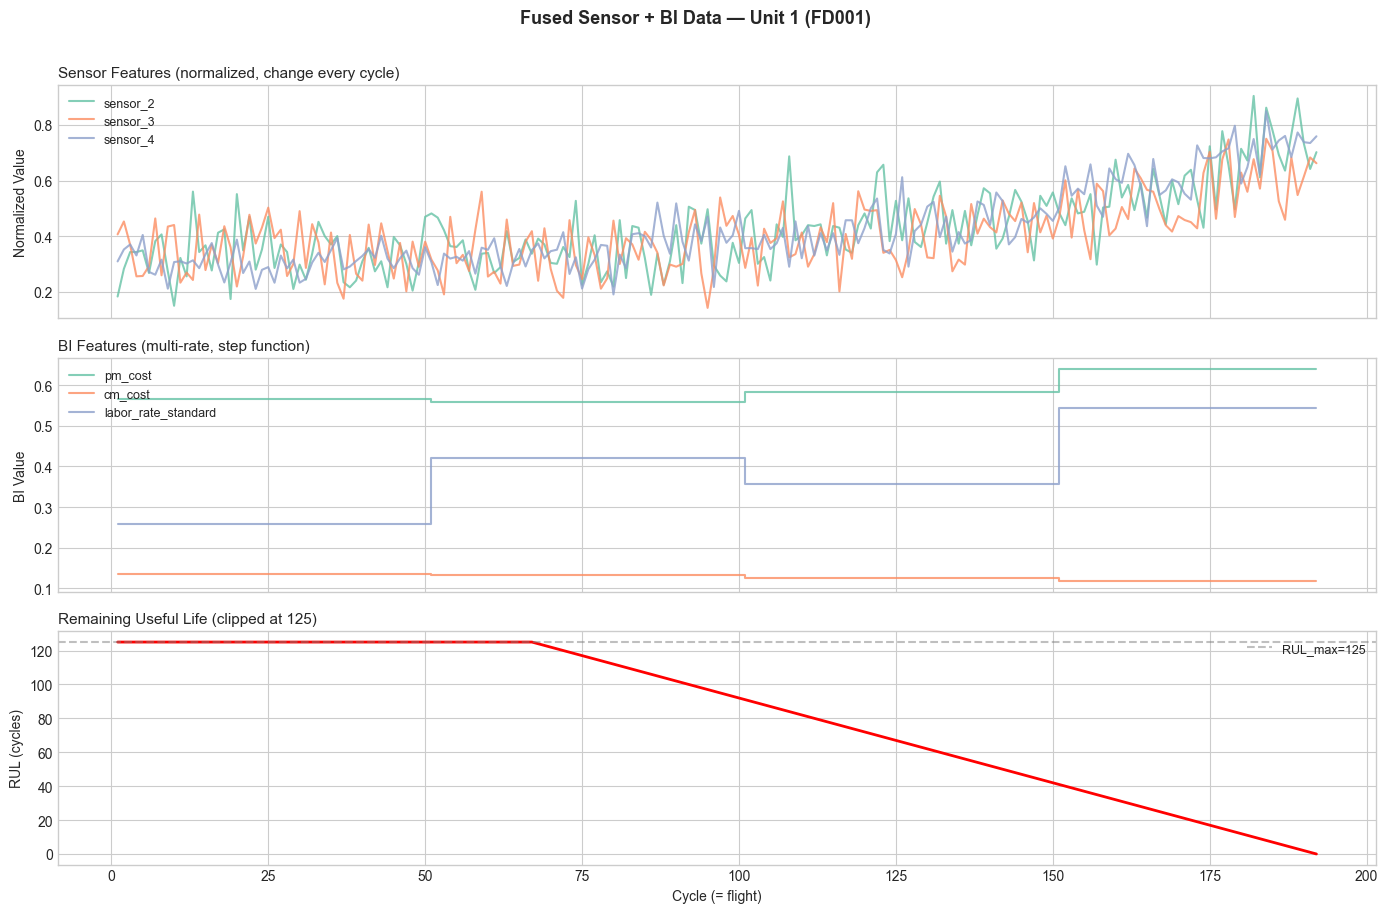

In [10]:
# Show one unit's fused features over its lifetime
unit_id = 1
unit_data = train_processed[train_processed['unit'] == unit_id].set_index('cycle')

# Pick a few representative features from each group
sensor_to_plot = [c for c in groups['sensor'] if c in unit_data.columns][:3]
bi_to_plot = [c for c in groups['bi'] if c in unit_data.columns 
              and not any(c.startswith(p) for p in ['production_priority_', 'shift_pattern_'])][:3]

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# Sensor features (normalized)
for col in sensor_to_plot:
    axes[0].plot(unit_data.index, unit_data[col], label=col, alpha=0.8)
axes[0].set_ylabel('Normalized Value')
axes[0].set_title('Sensor Features (normalized, change every cycle)', fontsize=11, loc='left')
axes[0].legend(loc='upper left', fontsize=9)

# BI features (original scale)
for i, col in enumerate(bi_to_plot):
    axes[1].step(unit_data.index, unit_data[col], where='post', 
                 label=col, alpha=0.8, linewidth=1.5)
axes[1].set_ylabel('BI Value')
axes[1].set_title('BI Features (multi-rate, step function)', fontsize=11, loc='left')
axes[1].legend(loc='upper left', fontsize=9)

# RUL
axes[2].plot(unit_data.index, unit_data['rul'], color='red', linewidth=2)
axes[2].axhline(y=125, color='gray', linestyle='--', alpha=0.5, label='RUL_max=125')
axes[2].set_ylabel('RUL (cycles)')
axes[2].set_xlabel('Cycle (= flight)')
axes[2].set_title('Remaining Useful Life (clipped at 125)', fontsize=11, loc='left')
axes[2].legend(loc='upper right', fontsize=9)

fig.suptitle(f'Fused Sensor + BI Data — Unit {unit_id} (FD001)', 
             fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

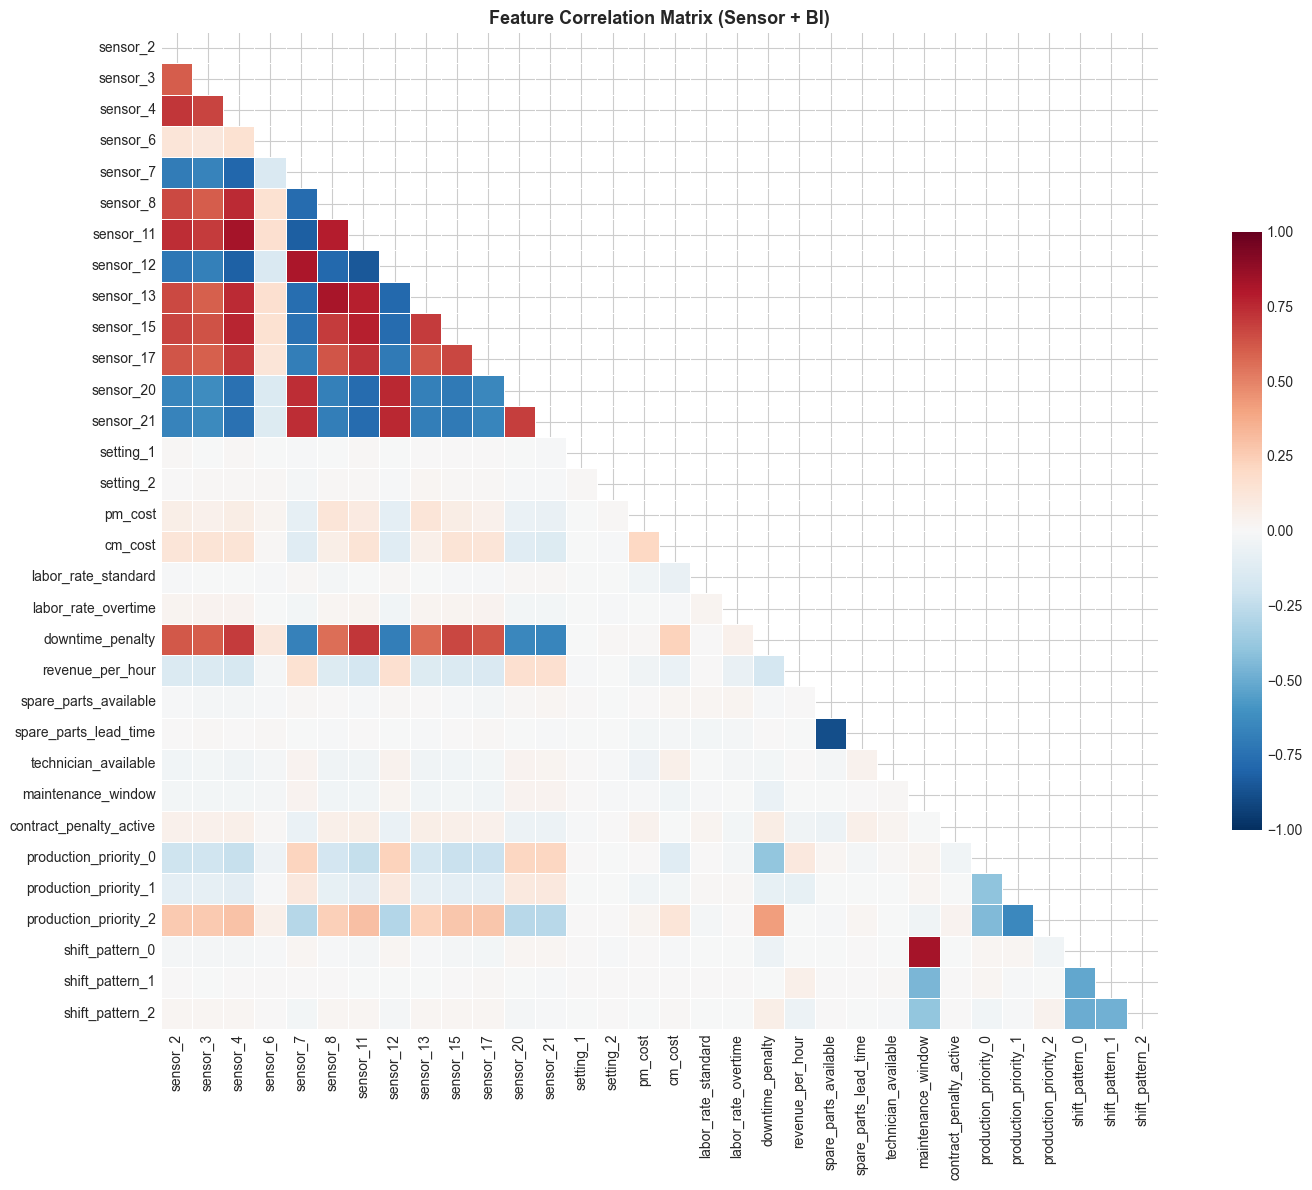

In [11]:
# Correlation heatmap: sensor vs BI features
all_features = groups['sensor'] + groups['setting'] + groups['bi']
# Keep only numeric columns that exist
plot_cols = [c for c in all_features if c in train_processed.columns]

corr = train_processed[plot_cols].corr()

fig, ax = plt.subplots(figsize=(16, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=ax, square=True,
            linewidths=0.5, cbar_kws={'shrink': 0.6})
ax.set_title('Feature Correlation Matrix (Sensor + BI)', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

---
## 6. Cost Realism Check

In [12]:
bi_full = bi_loader.load_bi('FD001')

print("=== BI Data Statistics (FD001) ===")
cost_cols = ['pm_cost', 'cm_cost', 'downtime_penalty', 'revenue_per_hour']
print(bi_full[cost_cols].describe().round(1))

cm_pm_ratio = bi_full['cm_cost'].mean() / bi_full['pm_cost'].mean()
print(f"\nCM/PM cost ratio: {cm_pm_ratio:.1f}x (industry standard: 5-10x)")

  BI data loaded: 20631 rows, 100 units
=== BI Data Statistics (FD001) ===
       pm_cost  cm_cost  downtime_penalty  revenue_per_hour
count  20631.0  20631.0           20631.0           20631.0
mean     500.4   3656.1            9754.7            8043.4
std       20.3    423.5            2909.1             621.8
min      453.9   3026.9            4087.0            6390.9
25%      488.1   3418.3            7242.6            7589.4
50%      499.3   3545.0            9700.9            8061.8
75%      513.2   3694.6           12186.7            8517.2
max      555.3   6286.3           15918.1            9675.4

CM/PM cost ratio: 7.3x (industry standard: 5-10x)


---
## 7. Multi-Dataset Validation (FD001-FD004)

In [13]:
results = {}

for ds_name in ['FD001', 'FD002', 'FD003', 'FD004']:
    print(f"\n{'='*60}")
    try:
        ds = loader.load_cmapss_dataset(ds_name)
        p = PreprocessingPipelineBI(rul_max=125)
        train_p = p.fit_transform(ds['train'], ds_name)
        test_p = p.transform(ds['test'], ds_name)
        g = p.get_feature_groups()
        results[ds_name] = {
            'train_shape': train_p.shape,
            'test_shape': test_p.shape,
            'n_sensor': len(g['sensor']),
            'n_setting': len(g['setting']),
            'n_bi': len(g['bi']),
            'total_features': len(g['all']),
            'status': '✓',
        }
    except Exception as e:
        print(f"  ✗ Failed: {e}")
        results[ds_name] = {'status': f'✗ {e}'}

print(f"\n{'='*60}")
print("\n=== Summary ===")
summary_df = pd.DataFrame(results).T
summary_df


Loading FD001 dataset...
  Files: train=True, test=True, rul=True
  - Training data shape: (20631, 26)
  - Training units: 100
  - Training RUL range: [0, 361]
  - Test data shape: (13096, 26)
  - RUL values shape: (100, 1)
  - Test units found: 100 (units: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]...)
  - RUL values provided: 100
    Unit 1: max_cycle=31, base_RUL=112
    Unit 2: max_cycle=49, base_RUL=98
    Unit 3: max_cycle=126, base_RUL=69
✓ FD001 loaded: 20631 train, 13096 test samples
PREPROCESSING PIPELINE — FD001

[Step 0] RUL clipped to max=125

[Step 1] Columns: 21 sensor, 3 setting

[Step 2] Normalized 24 features (minmax)

=== BI Fusion: FD001 (train) ===
  Sensor data: (20631, 27)
  BI data loaded: 20631 rows, 100 units
  Fused data: (20631, 44)
  Features: 21 sensor + 17 BI

[Step 3b] Normalized 7 continuous BI features (minmax)
  Normalized: ['pm_cost', 'cm_cost', 'labor_rate_standard', 'labor_rate_overtime', 'downtime_penalty', 'revenue_per_hou

,train_shape,test_shape,n_sensor,n_setting,n_bi,total_features,status
FD001,"(20631, 35)","(13096, 35)",13,2,17,32,✓
FD002,"(53759, 27)","(33991, 27)",5,2,17,24,✓
FD003,"(24720, 33)","(16596, 33)",11,2,17,30,✓
FD004,"(61249, 27)","(41214, 27)",6,1,17,24,✓


---
## 8. Methodology Alignment Summary

This section maps each pipeline step to the corresponding section in the thesis methodology.

| Pipeline Step | Code Module | Methodology Section | Equation(s) | Status |
|:---|:---|:---|:---|:---|
| Data loading (C-MAPSS) | `data_loader.py` | III-B1 (Data Acquisition) | — | ✓ |
| RUL calculation & clipping | `preprocessing.py` | III-B2 (Piecewise Linear RUL) | Eq. 1-2 | ✓ |
| BI data temporal alignment | `bi_fusion.py` | III-B3 (BI Data Fusion) | Eq. 3-4 | ✓ |
| Source-driven Δ_k per variable | `bi_fusion.py` (`BI_DELTA_CONFIG`) | III-B3 (Update Frequencies) | — | ✓ |
| One-hot encoding of categoricals | `bi_fusion.py` (`_encode_categoricals`) | III-B3 (Eq. 5) | Eq. 5 | ✓ |
| Feature-level fusion (concat) | `bi_fusion.py` (`fuse`) | III-B3 (Eq. 6) | Eq. 6 | ✓ |
| Min-Max normalization | `preprocessing.py` (`DataNormalizer`) | III-B4 (Normalization) | Eq. 7-8 | ✓ |
| Variance-based filtering (sensor only) | `feature_selection.py` | III-B4 (Eq. 10) | Eq. 10 | ✓ |
| BI exemption from variance filter | `feature_selection.py` | III-B4 (BI-aware selection) | — | ✓ |
| Correlation-based filtering | `feature_selection.py` | III-B4 (Eq. 12) | Eq. 12 | ✓ |
| BI prioritization in corr. removal | `feature_selection.py` | III-B4 (BI retention) | — | ✓ |

### What remains for the next steps:

| Next Step | Methodology Section | Status |
|:---|:---|:---|
| Sliding window generation | III-B5 (Sequence Construction) | ⬜ To do |
| GA hyperparameter optimization | III-B4 (Eq. 14-15) | ⬜ To do |
| Attention mechanism (BI-sensor weighting) | III-C2 (Eq. 16-18) | ⬜ To do |
| Hybrid ML+DL model (XGBoost + CNN-LSTM) | III-C3-C4 (Eq. 19-32) | ⬜ To do |
| SHAP explainability | III-D2 | ⬜ To do |
| Cost-sensitive decision support | III-D3-D4 (Eq. 45-49) | ⬜ To do |